<a href="https://colab.research.google.com/github/SumathiGit/Python-World/blob/main/Style_Transfer_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline 
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
vgg = models.vgg19(pretrained=True).features                                                                                #only getting the features from the dataset not the classifier

for param in vgg.parameters():
    param.requires_grad_(False)                                                                                              #Setting requires_grad function into False is helps to the parameters that they not updating the weights

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
#In the above cell we have got the summary of the vgg 19 model Architecture with their specific layer number...FC models are not shown in the summary only the convolution layer details are here

In [ ]:
def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:                                                                                   #Style transfer is more effective when the size and dimension of the content image as the same as the style image ... Where in some case we don't get the same size >>>> For that we are using shape argument 
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), 
                                             (0.5,))])

    image = in_transform(image).unsqueeze(0)
    
    return image

In [ ]:
content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg').to(device)

In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()                                                                                    #For removing the single dimensional entries from the image
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

(-0.5, 615.5, 399.5, -0.5)

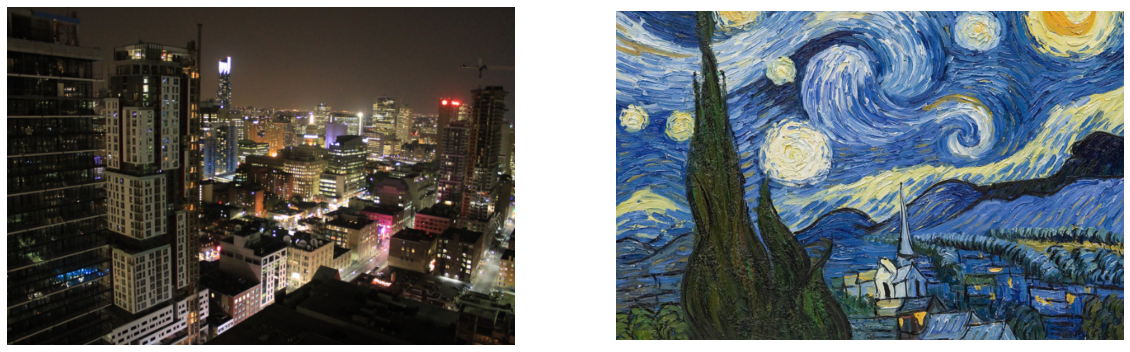

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))                                                                         #Grid arrangements of 1 row with 2 columns
ax1.imshow(im_convert(content))                                                                                                #Content image on the left which focus on the objects in the image such as buildings , features etc.. 
ax1.axis("off")
ax2.imshow(im_convert(style))                                                                                                  #style image on the right side focus on the colors and Texture on the image
ax2.axis("off")

In [ ]:
#Feature Extraction

In [ ]:
def get_features(image, model):                                                                                     #We are choosing layers for feature extraction with their respective layer number in the model architecture 
     
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1',                                                                                      #This layers are chosen by >>  https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
              '19': 'conv4_1',                                                                                      #We can change them in order to get our own satisfied output image   
              '21': 'conv4_2', #  >>> for content extraction  others are for style extraction                               
              '28': 'conv5_1'}
        
    features = {}               #Empty features dictionary for storing all the extracted data

    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [ ]:
#Gram_Matrix >> Applying a gram matrix to feature extracted from convolutional neural networks helps to create texture information related to the data 
#Gram = V transpose T * V

In [ ]:
def gram_matrix(tensor):                                                                       #We are currently having four dimensional images as tensors >> changing them into 2D tensor 
    _, d, h, w = tensor.size()                                                                 #Going to change the size with the batch size, depth,width,height of the image
    tensor = tensor.view(d, h * w)                                                             # h * w  represent the extracted feature from the image and D >> depth represent the no of feature channel in our tensor image

#Now we get the 2D tensor image Next step is to apply gram_matrix

    gram = torch.mm(tensor, tensor.t())                       #mm comment for multiplying two matrices
    return gram

In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [ ]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha for content image weight
style_weight = 1e6  # beta  for style image weight

In [ ]:
target = content.clone().requires_grad_(True).to(device)                 #for the final output target image

In [ ]:
#Optimization 


show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100

#For Data Visualization For the target image (tensor)
 
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

In [ ]:
 #Mean  square  error  (MSE) -Mean  Squared  Error (MSE) is defined as the square of differences in the pixel  values  between  the  corresponding  pixels  of the two images. The mean square error (MSE) of N * M size image is given by,MSE= ΣM, N [I1 (m, n) –I2 (m, n)] 2 / (M*N)  M  &N -number  of  rows  and  columns  in  the  input images.

Total loss:  3143931.5
Iteration:  300


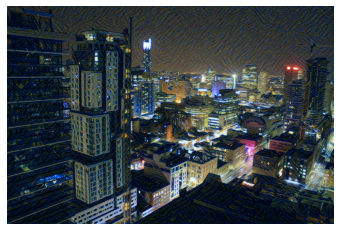

Total loss:  1026134.1875
Iteration:  600


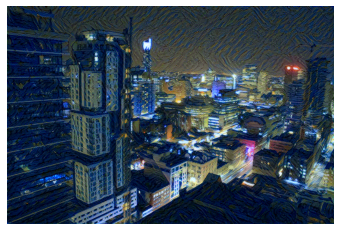

Total loss:  699779.0625
Iteration:  900


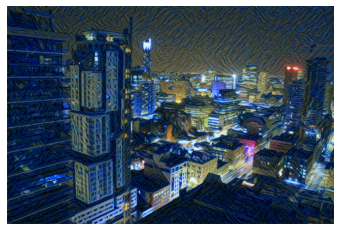

Total loss:  542128.625
Iteration:  1200


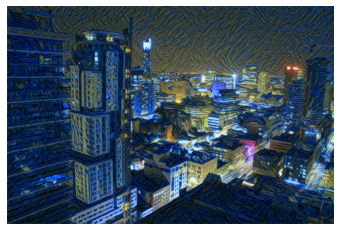

Total loss:  426285.5
Iteration:  1500


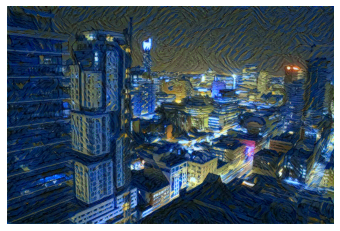

Total loss:  335926.0625
Iteration:  1800


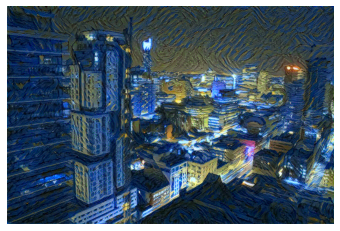

Total loss:  264163.375
Iteration:  2100


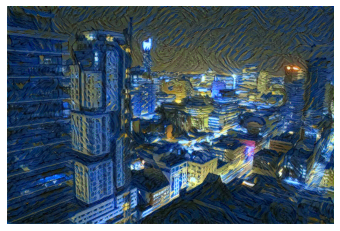

In [ ]:
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)                                 #Applying mean-square error (MSE) formula 
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)                                            ##Calculating the loss for all five layers                        
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)                                                                            
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1


(-0.5, 599.5, 399.5, -0.5)

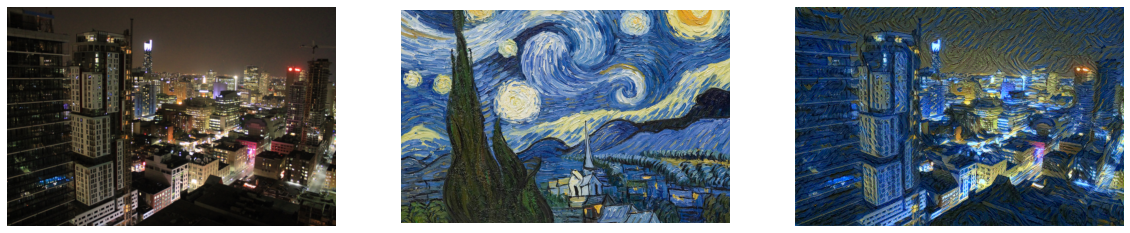

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [ ]:
#Coverting the style process into the mp4 video format and also save them by using below codes

In [ ]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [ ]:
!ls 

City.jpg  output.mp4  sample_data  StarryNight.jpg


In [ ]:
#We can download our rendered video using google.colab import files

In [26]:
from google.colab import files
files.download('output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>